In [36]:
import scipy.io
from os import listdir
from os.path import isfile, join
import pandas as pd

from collections import defaultdict


from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns


from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

import tensorflow as tf
import shap
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import  Dropout
from tensorflow.keras.optimizers import Adam

### 1. Data Loading and Preprocessing

In [37]:
x=np.load('scalar_in.npy')
y=np.load('scalar_out_OTR2.npy')

In [38]:
x.shape, y.shape

((32607, 13), (32607, 14))

In [39]:
scaler = MinMaxScaler()
scaler.fit(x)
X=scaler.transform(x)
print(np.min(X,axis=0))
print(np.max(X,axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [40]:
target_names=['n_particle', 'mean_gamma', 'sigma_gamma','norm_emit_x', 'norm_emit_y',
'sigma_x', 'sigma_y', 'sigma_z','sigma_px', 'sigma_py', 'sigma_pz',   
'mean_z',  'higher_order_energy_spread','cov_x__px', 'cov_z__pz', 'cov_y__py']

In [41]:
feature_names=['distgen:r_dist:sigma_xy:value',
 'distgen:t_dist:length:value',
 'SOL1:solenoid_field_scale',
 'CQ01:b1_gradient',
 'SQ01:b1_gradient',
 'L0A_phase:dtheta0_deg',
 'L0B_phase:dtheta0_deg',
 'QA01:b1_gradient',
 'QA02:b1_gradient',
 'QE01:b1_gradient',
 'QE02:b1_gradient',
 'QE03:b1_gradient',
 'QE04:b1_gradient']

for i in range(13):
    print(i, " -- ", feature_names[i])

(0, ' -- ', 'distgen:r_dist:sigma_xy:value')
(1, ' -- ', 'distgen:t_dist:length:value')
(2, ' -- ', 'SOL1:solenoid_field_scale')
(3, ' -- ', 'CQ01:b1_gradient')
(4, ' -- ', 'SQ01:b1_gradient')
(5, ' -- ', 'L0A_phase:dtheta0_deg')
(6, ' -- ', 'L0B_phase:dtheta0_deg')
(7, ' -- ', 'QA01:b1_gradient')
(8, ' -- ', 'QA02:b1_gradient')
(9, ' -- ', 'QE01:b1_gradient')
(10, ' -- ', 'QE02:b1_gradient')
(11, ' -- ', 'QE03:b1_gradient')
(12, ' -- ', 'QE04:b1_gradient')


This is where we specify the target. The targets, names and indices are outlined above.
In this example, we are illustrating the flow with the (log) of the GM of the emittances. 

In [42]:
y_target=0.5*(np.log(y[:,3])+np.log(y[:,4]))
print(np.min(y_target,axis=0))
print(np.max(y_target,axis=0))
print(np.mean(y_target,axis=0))

-14.420605960308079
-10.35463706794712
-13.900184295746097


In [43]:
X.shape, y_target.shape

((32607, 13), (32607,))

In [44]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y_target, test_size=0.2, random_state=42)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((26085, 13), (26085,), (6522, 13), (6522,))

### 2.a Model Specification and Training

In [45]:
model=Sequential()
model.add(Dense(20, activation='relu',input_shape=(13,)))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                420       
__________

In [46]:
# Batch size
BATCH_SIZE = 128

# Number of training epochs
EPOCHS = 10000

# Learning rate
L_RATE = 1e-5

In [47]:
model.compile(tf.keras.optimizers.Adam(lr=L_RATE),loss='mse')

In [ ]:
%%time
history = model.fit(X_train, Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val,Y_val))

In [ ]:
model.save("CuInjSim_EmitGM_Model")

### 2.b Model Loading

In [48]:
model = tf.keras.models.load_model("CuInjSim_EmitGM_Model")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 20)                280       
_________________________________________________________________
dense_28 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_29 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_30 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_31 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_32 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_33 (Dense)             (None, 20)                420       
__________

### 3. Model Verification

In [49]:
ytemppred=model.predict(X_val)
Y_val.shape,ytemppred.shape

indx=np.argsort(Y_val[:])
ytemp=Y_val[indx]
predtemp=ytemppred[indx,0]

y_filtered=ytemp[::8]
pred_filtered=predtemp[::8]

xd=np.arange(pred_filtered.shape[0])

y_filtered.shape,pred_filtered.shape,xd.shape

((816,), (816,), (816,))

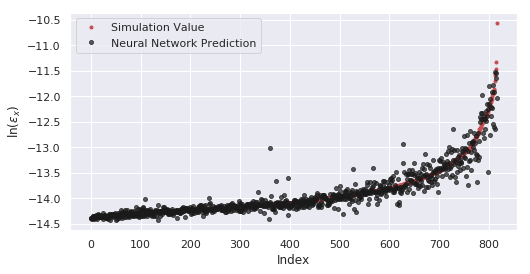

In [50]:
plt.figure(figsize=(8,4))
#indx=np.argsort(y_val[:,0])
plt.plot(y_filtered,'.r',label='Simulation Value')
plt.plot(pred_filtered,'ok',alpha=0.7,label='Neural Network Prediction',markersize=4)
#plt.errorbar(xd,pred_filtered,yerr=err_filtered,fmt='ok',capthick=2,capsize=2,alpha=0.2,label='BNN Standard Error')
plt.xlabel('Index')
plt.ylabel('ln($\epsilon_x$)')
plt.legend()
#plt.xlim(-2,235)
#plt.ylim(0.35,2.45)

### 4. Model Validation and Discovery

In [62]:
N=5000

In [51]:
#Cluster examples to speed up computation
background = X_train[np.random.choice(X_train.shape[0], 500, replace=False)]

In [52]:
#Use the clustered examples to split features
df_train_normed_summary = shap.kmeans(X_train, 25)

In [53]:
#Instantiate general explainer
explainer = shap.KernelExplainer(model.predict, df_train_normed_summary)

In [ ]:
#Calculate Shap Values
shap_values = explainer.shap_values(X_train[:N,:])

Let's take a moment to look at the shap_values.
This variable is a list, whose 1st (or zeroth) element is all we need.

This element shap_values[0] is a numpy array, of dimensions (N_samples, N_features)
So, for each sample that we passed to the explainer, it calculates the impact of each of the values of the features for that sample, over the mean.

For example, shap_values[0][3,:] is a 13 dimensional vector, that looks at the 4th sample point given to the explainer. Let this vector be [1,0,0,0,0,0,0,0,0,0,0,0,-5]. This vector suggests that the prediction for this sample by the model was increased 1 unit by the value of the 0-th feature value of this sample, and was decreased by 5 units by the last feature's value for this sample. Each of these impacts is measured relative to the mean value of that feature over all the samples.

In [56]:
shap_values[0].shape

(50, 13)

Text(0.5,0,'Global Importance of Feature')

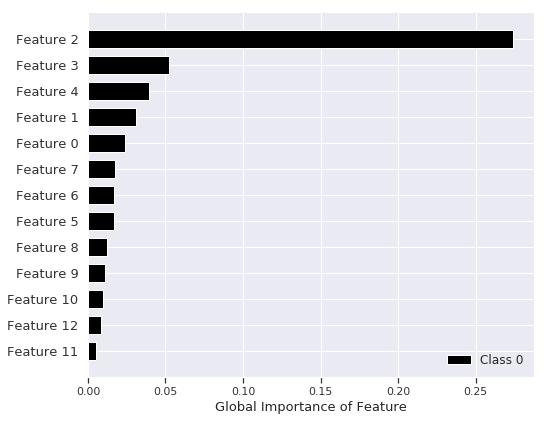

In [58]:
#Global Impact/Importance of each feature
shap.summary_plot(shap_values, features=X_train[:N,:], plot_type="bar", show=False)

plt.xlabel("Global Importance of Feature")

Text(0,0.5,'Impact of Feature of Prediction')

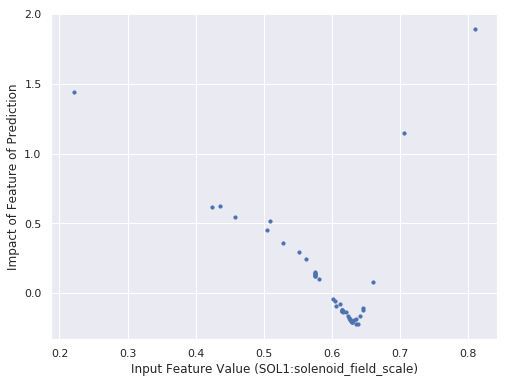

In [61]:
# Looking at the impacts of individual features. "t" selects the t-th feature and then the plot 
# shows the impact of the impact of this feature for each of the training samples.
# Here we are showing this for t=2, or the solenoid setting
t=2
plt.figure(figsize=(8,6))
plt.scatter(X_train[:N,t],shap_values[0][:,t],s=10)

plt.xlabel("Input Feature Value "+"("+feature_names[t]+")")
plt.ylabel("Impact of Feature of Prediction")
